# Data extraction

In [1]:
import numpy as np
import pandas as pd
import datetime
import os

In [2]:
df = pd.read_csv("./data/LSTM_with_PyTorch.csv")

In [3]:
df

,Value,Date
0,13.706000,20191202
1,14.267895,20191202
2,14.283784,20191202
3,14.054737,20191202
4,14.075263,20191202
...,...,...
3916,14.091667,20191126
3917,14.074595,20191126
3918,14.008108,20191126
3919,13.968333,20191126


# Data Preparation

In [24]:
df = df.sort_values(by="Date", ascending=True)
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='ISO8601'))

In [25]:
df

,Value,Date
587,13.855263,2019-11-25
2617,13.734286,2019-11-25
2618,14.007027,2019-11-25
2619,13.869730,2019-11-25
2620,13.608000,2019-11-25
...,...,...
3622,13.853158,2020-02-07
3624,13.983243,2020-02-07
3623,13.987333,2020-02-07
2557,13.832432,2020-02-07


In [26]:
df.index = df.Date
df['Value'] = df.resample('D')['Value'].min()
df = df.drop_duplicates()
df = df.asfreq('D')
df = df.ffill(axis = 0)

In [27]:
df

,Value,Date
Date,,
2019-11-25,13.572000,2019-11-25
2019-11-26,13.888800,2019-11-26
2019-11-27,13.010000,2019-11-27
2019-11-28,5.971053,2019-11-28
2019-11-29,12.562308,2019-11-29
...,...,...
2020-02-03,13.709474,2020-02-03
2020-02-04,13.617333,2020-02-04
2020-02-05,13.503636,2020-02-05


# Data Visualization

In [28]:
import plotly.graph_objects as go

In [29]:
tracel = go.Scatter(
    x=df.index, 
    y=df.Value,
    mode="lines",
    name="Ground Truth"
)

In [30]:
layout = go.Layout(
    title="Signal Value Plot",
    xaxis={"title": "Date"},
    yaxis={"title": "Close"}
)


In [31]:
fig = go.Figure(data=[tracel], layout=layout)
fig.show()


In [32]:
import torch
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 36, 18
register_matplotlib_converters()

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Data Exploration

In [33]:
df = df.drop(['Date'], axis=1)

In [34]:
test_data_size = 20
train_data = df[:-test_data_size].values
test_data = df[-test_data_size:].values

In [35]:
test_data.shape

(20, 1)

In [36]:
train_data.shape

(55, 1)

In [37]:
scaler = MinMaxScaler()

scaler = scaler.fit(train_data)

train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)

In [38]:
test_data

array([[0.9747878 ],
       [0.91621245],
       [0.94918781],
       [0.9796955 ],
       [0.98100547],
       [0.98100547],
       [0.98100547],
       [0.98100547],
       [0.96148695],
       [0.9584068 ],
       [0.95081761],
       [0.96279692],
       [0.93668842],
       [0.95783283],
       [0.95783283],
       [0.93768001],
       [0.92651518],
       [0.91273829],
       [0.89169842],
       [0.94851827]])

In [39]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [40]:
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [41]:
X_train.shape

torch.Size([44, 10, 1])

# Build Model

In [42]:
class BatterySignalPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(BatterySignalPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## Train

In [43]:
def train_model(
    model,
    train_data,
    train_labels,
    test_data=None,
    test_labels=None
):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
    num_epochs = 300

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()

        y_pred = model(X_train)

        loss = loss_fn(y_pred.float(), y_train)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()

            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    return model.eval(), train_hist, test_hist

In [44]:
model = BatterySignalPredictor(
    n_features=1,
    n_hidden=700,
    seq_len=seq_length,
    n_layers=2
)
model, train_hist, test_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test
)

Epoch 0 train loss: 35.90650177001953 test loss: 7.273853778839111
Epoch 10 train loss: 15.077482223510742 test loss: 3.1151058673858643
Epoch 20 train loss: 4.971467018127441 test loss: 1.064538836479187
Epoch 30 train loss: 3.9887914657592773 test loss: 0.7489996552467346
Epoch 40 train loss: 0.19669803977012634 test loss: 0.017091885209083557
Epoch 50 train loss: 0.22816555202007294 test loss: 0.025368090718984604
Epoch 60 train loss: 0.18839135766029358 test loss: 0.008249064907431602
Epoch 70 train loss: 0.15422995388507843 test loss: 0.005002181977033615
Epoch 80 train loss: 0.16984543204307556 test loss: 0.011036951094865799
Epoch 90 train loss: 0.16072095930576324 test loss: 0.004536973312497139
Epoch 100 train loss: 0.15208888053894043 test loss: 0.005669691599905491
Epoch 110 train loss: 0.15106622874736786 test loss: 0.008271949365735054
Epoch 120 train loss: 0.15123867988586426 test loss: 0.008632522076368332
Epoch 130 train loss: 0.15079927444458008 test loss: 0.0078776264

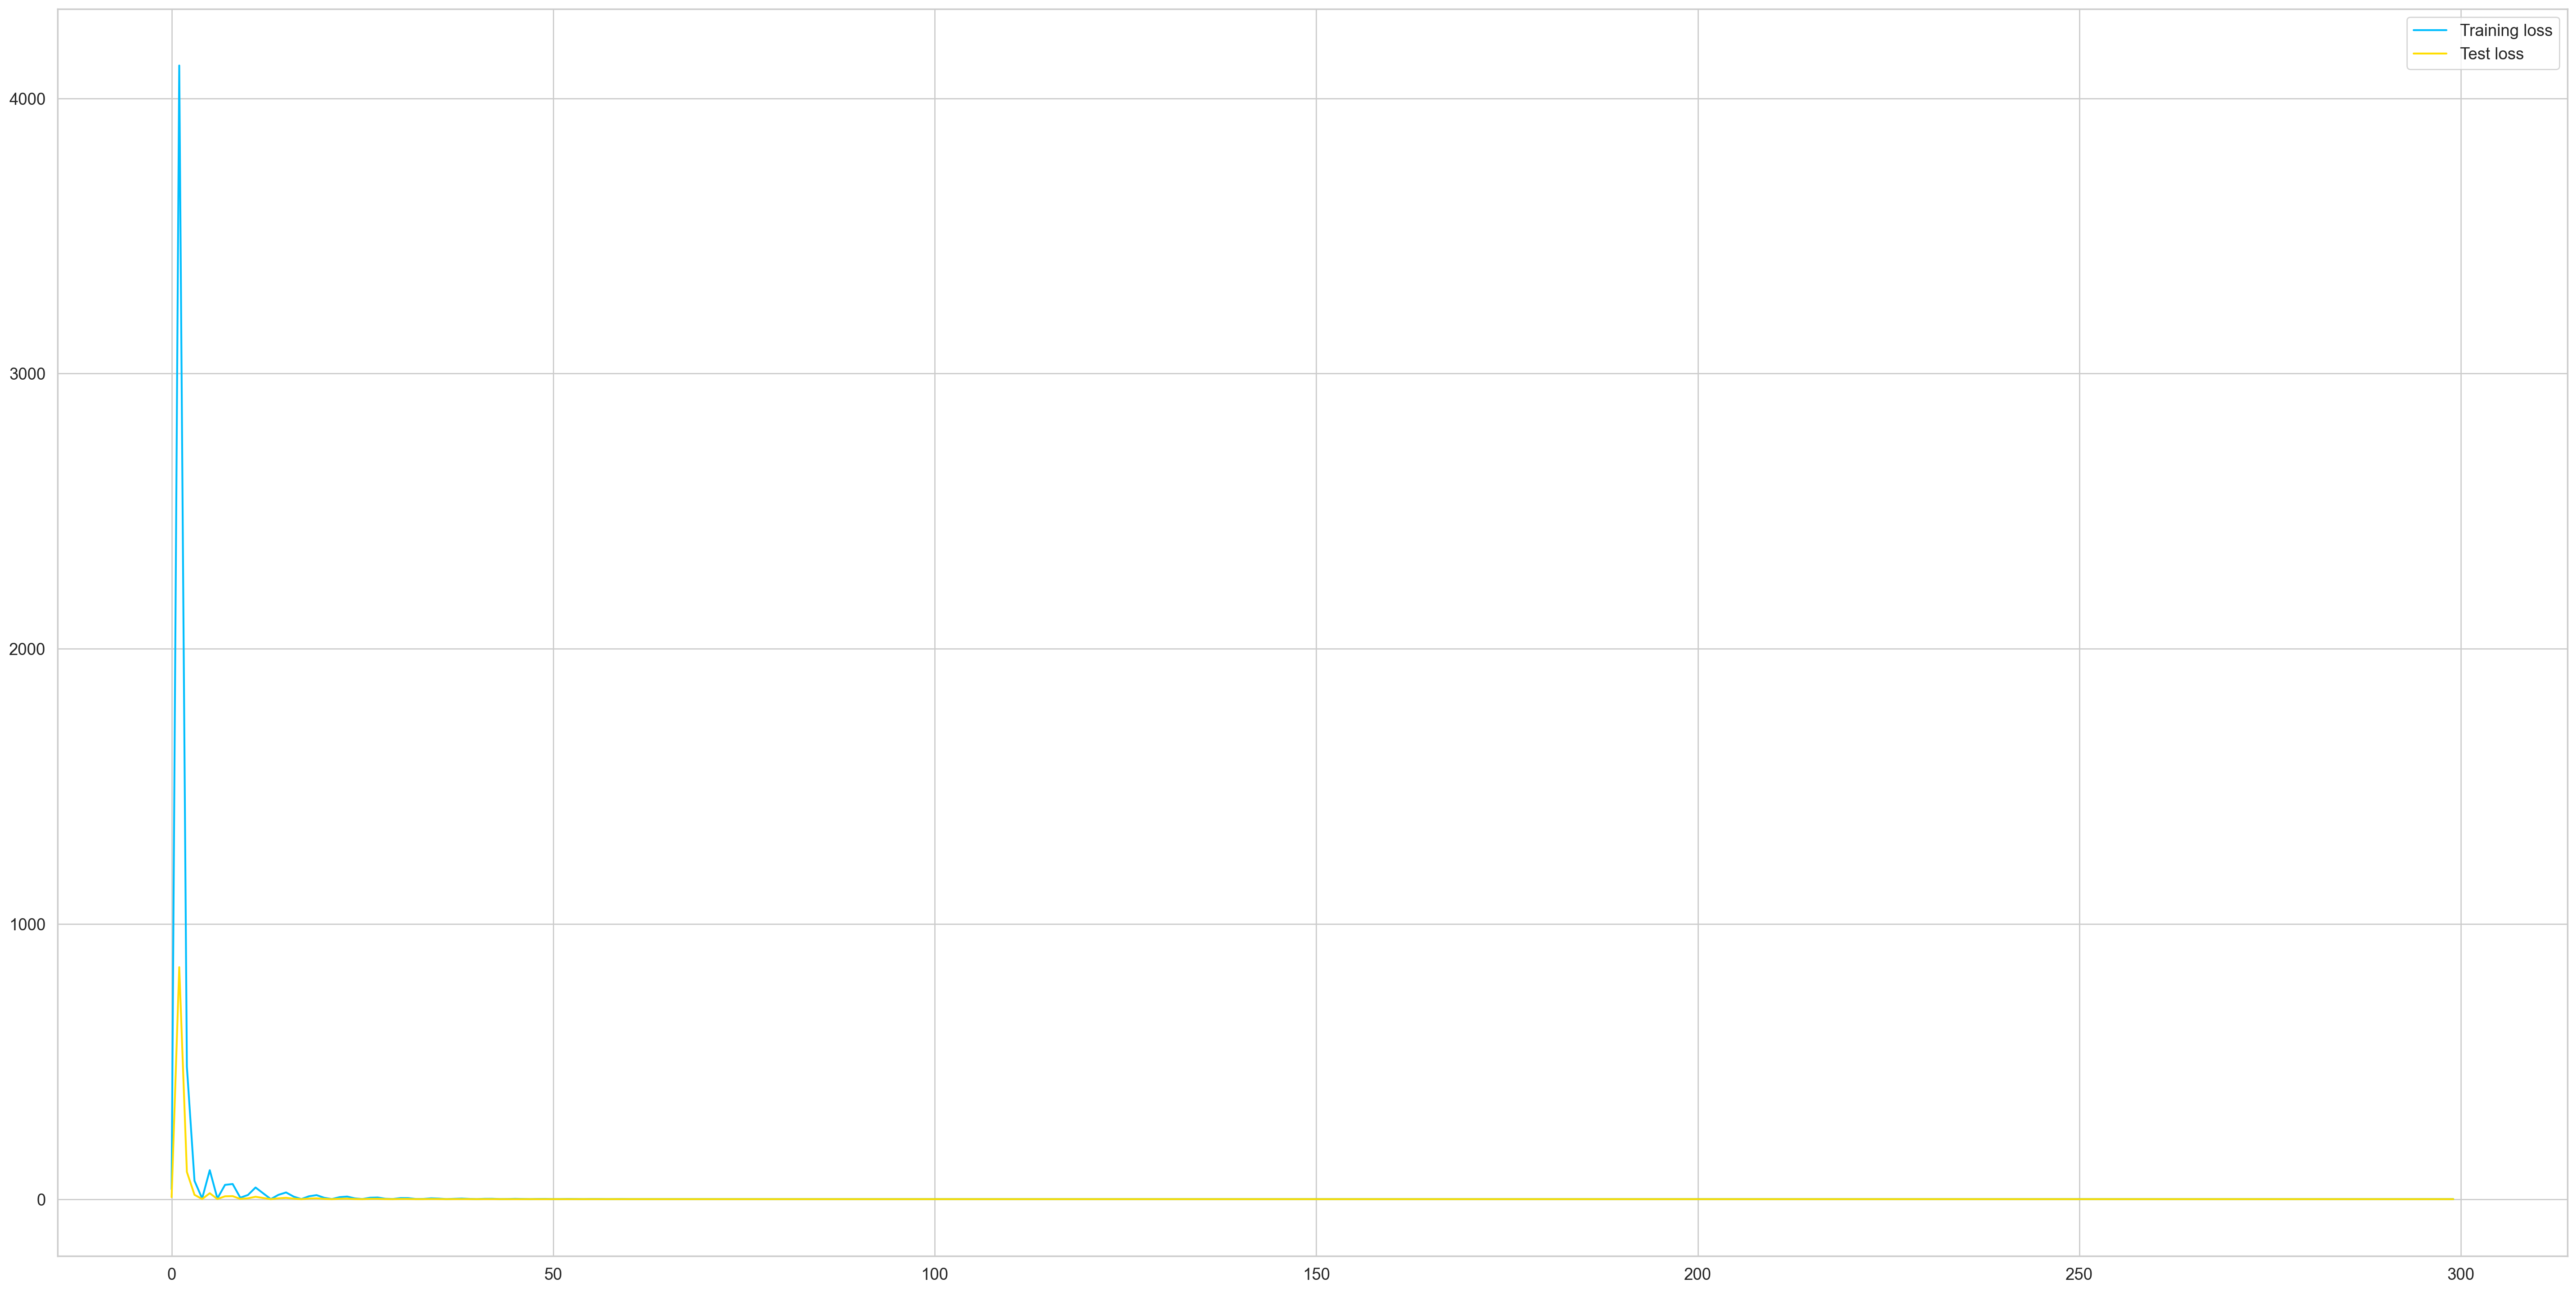

In [45]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
# plt.ylim((0, 5))
plt.legend();

## Predict Daily Signals

In [46]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [47]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

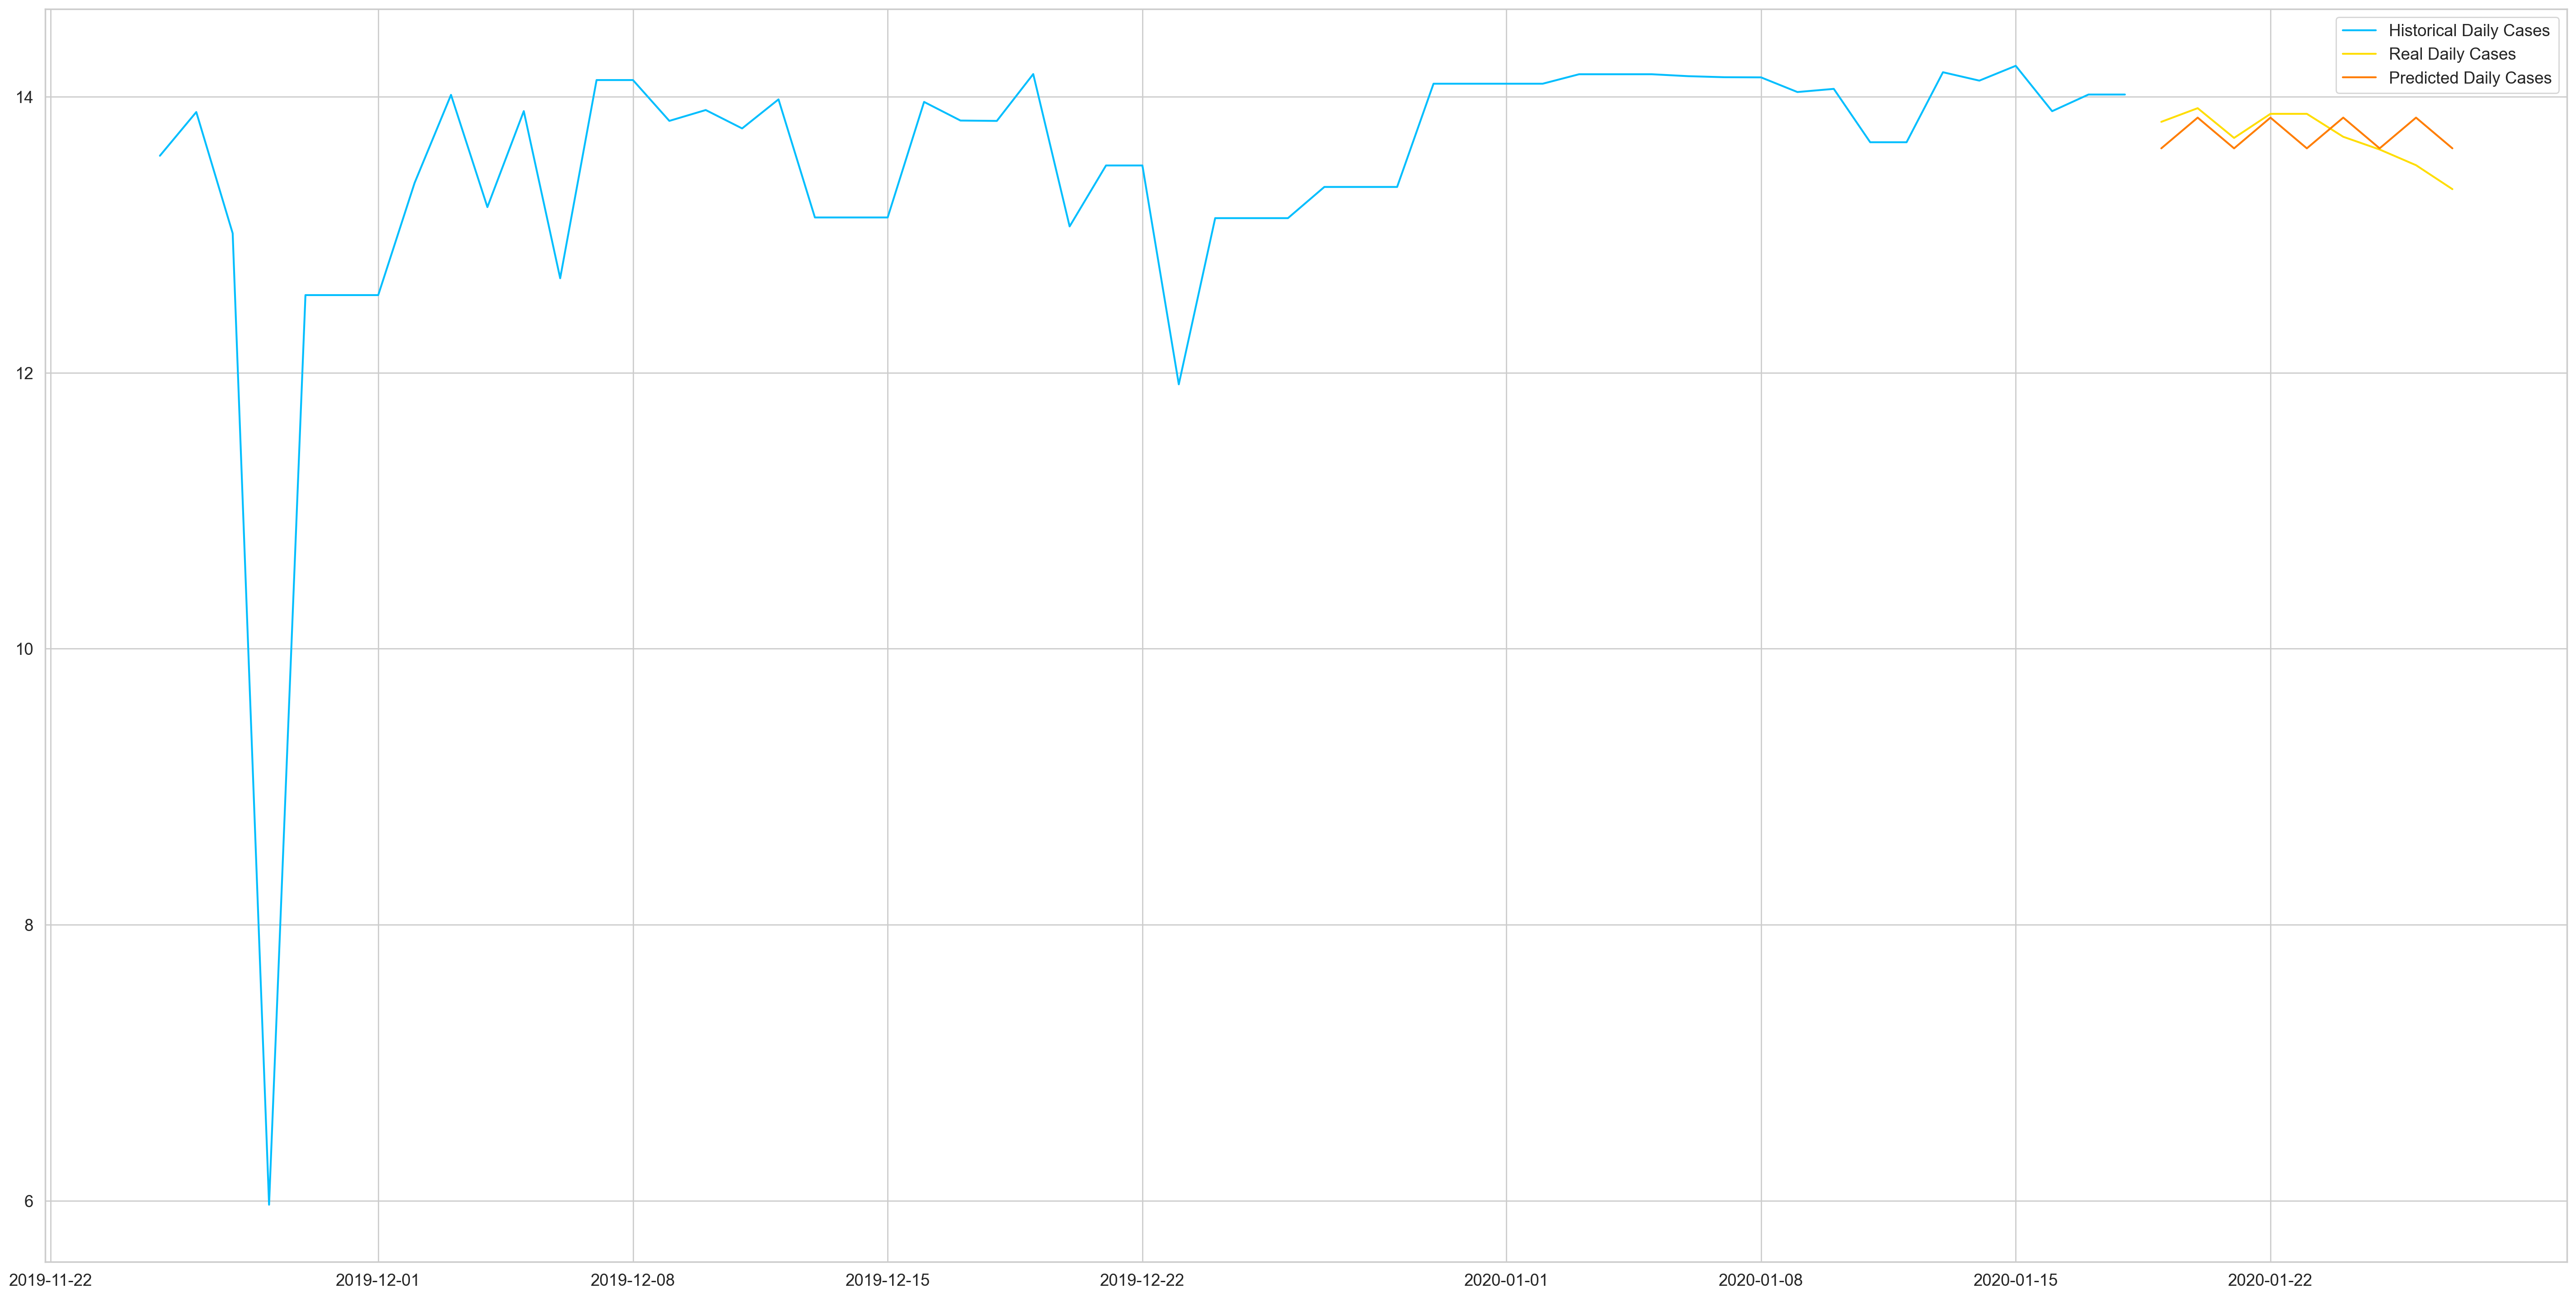

In [48]:
plt.plot(
  df.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  df.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  df.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend();

# Save model

In [49]:
torch.save(model.state_dict(), './best.pt')

In [50]:
model = BatterySignalPredictor(
    n_features=1,
    n_hidden=700,
    seq_len=seq_length,
    n_layers=2
)

In [51]:
model.load_state_dict(torch.load('./best.pt'))

<All keys matched successfully>

In [74]:
len(model.lstm.all_weights[0])

4

In [ ]:
4, 2800, 700